In [299]:
import tensorflow as tf
from keras import layers, models
from keras.layers import Normalization, Lambda
from keras.models import load_model
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split

In [300]:
def create_global_view(initial_layer = 32):
    inputs = layers.Input(shape=(None, 3))  # Assuming the logs are 1D sequences
    
    x = layers.Masking(mask_value=-99)(inputs)  # Using -99 as the mask value

    # Encoding layer 1
    conv1 = layers.Conv1D(initial_layer, 3, activation="relu", padding="same")(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(0.5)(conv1)
    pool1 = layers.MaxPooling1D()(conv1)

    # Encoding layer 2
    conv2 = layers.Conv1D(2*initial_layer, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Dropout(0.5)(conv2)
    pool2 = layers.MaxPooling1D()(conv2)

    # Middle layer
    conv_middle = layers.Conv1D(4*initial_layer, 3, activation="relu", padding="same")(pool2)
    conv_middle = layers.BatchNormalization()(conv_middle)
    conv_middle = layers.Dropout(0.5)(conv_middle)

    # Decoding layer 1
    up1 = layers.UpSampling1D()(conv_middle)
    
    # # Ensure sizes match before concatenating
    # cropped_conv2 = layers.Cropping1D(cropping=((1,0)))(conv2)
    merge1 = layers.concatenate([conv2, up1])
    
    decode1 = layers.Conv1D(2*initial_layer, 3, activation="relu", padding="same")(merge1)
    decode1 = layers.BatchNormalization()(decode1)
    decode1 = layers.Dropout(0.5)(decode1)

    # Decoding layer 2
    up2 = layers.UpSampling1D()(decode1)
    
    # Ensure sizes match before concatenating for the second merge
    # cropped_conv1 = layers.Cropping1D(cropping=((2,0)))(conv1)  # Adjusted cropping
    merge2 = layers.concatenate([conv1, up2])

    decode2 = layers.Conv1D(initial_layer, 3, activation="relu", padding="same")(merge2)
    decode2 = layers.BatchNormalization()(decode2)
    decode2 = layers.Dropout(0.5)(decode2)

    return models.Model(inputs, decode2)


In [301]:
# Local View
def create_local_view(initial_layer = 16):
    inputs = layers.Input(shape=(None, 3))
    x = layers.Masking(mask_value=-99)(inputs)  # Using -99 as the mask values
    
    # Inception layers with dilated convolutions
    conv1 = layers.Conv1D(initial_layer, 1, padding="same", dilation_rate=1)(x)
    conv3 = layers.Conv1D(initial_layer, 3, padding="same", dilation_rate=8)(x)
    concat = layers.Concatenate()([conv1, conv3])
    return models.Model(inputs, concat)

In [302]:
# Normalize function
def normalize_data(data, mean, std):
    return (data - mean) / std


def ensure_even_length(sequence, padding_value=-99):
    # If the sequence length is odd, append padding to make it even
    if sequence.shape[0] % 2 != 0:
        padding_shape = list(sequence.shape)
        padding_shape[0] = 1  # we only need to add one row
        
        # Create a padding with the same number of columns as the sequence
        padding = np.full(padding_shape, padding_value)
        
        # Append padding to the sequence
        sequence = np.vstack([sequence, padding])
        
    return sequence

def pad_to_max_length(sequence, max_length, padding_value=-99):
    padding = [(0, max_length - sequence.shape[0]), (0, 0)]
    return np.pad(sequence, padding, mode='constant', constant_values=padding_value)


# Define a Gaussian smoothening function
def smooth_labels(y, sigma=3):
    return gaussian_filter1d(y, sigma)

def adjust_max_length(max_length):
    last_digit = max_length % 10
    
    if last_digit in [2, 6]:
        return max_length + 2
    elif last_digit == 0:
        return max_length + 4
    else:
        return max_length


In [303]:
current_dir = os.getcwd()
# Train your model here
folder_path = current_dir + "/Data/Train_Validate/"
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

dfs = []
for file in files:
    df = pd.read_csv(folder_path + file)
    dfs.append(df)

train_dfs, val_dfs = train_test_split(dfs, test_size=0.2, random_state=42) # Here 20% of the data is kept for validation

features = ["GR", "ILD", "DPHI"]

# Compute the mean and standard deviation of the training data
all_train_data = np.vstack([df[features].values for df in train_dfs])
mean = np.mean(all_train_data, axis=0)
std = np.std(all_train_data, axis=0)

# Extract features and labels for training and validation sets
X_train = np.array([df[features].values for df in train_dfs])
y_train = np.array([df["Pick"].values for df in train_dfs])

X_val = np.array([df[features].values for df in val_dfs])
y_val = np.array([df["Pick"].values for df in val_dfs])

# # Apply smoothening to your labels
# y_train = [np.clip(smooth_labels(y), 0, 1) for y in y_train]
# y_val = [np.clip(smooth_labels(y), 0, 1) for y in y_val]

# Apply smoothening to your labels
y_train = [smooth_labels(y) for y in y_train]
y_val = [smooth_labels(y) for y in y_val]


# Normalize data
X_train = [normalize_data(x, mean, std) for x in X_train]
X_val = [normalize_data(x, mean, std) for x in X_val]

# Ensure even length
X_train = [ensure_even_length(x) for x in X_train]
X_val = [ensure_even_length(x) for x in X_val]

# Compute max_length after ensuring even lengths
max_length = max(max(x.shape[0] for x in X_train), max(x.shape[0] for x in X_val))+2

# The UNET structure requires the total size of the input when divided by 4  or divided by 2 be even. 
max_length = adjust_max_length(max_length)

# Pad to max_length
X_train = [pad_to_max_length(x, max_length) for x in X_train]
X_val = [pad_to_max_length(x, max_length) for x in X_val]

# Ensure even length for labels and then pad
y_train = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_train]
y_val = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_val]

y_train = [pad_to_max_length(y, max_length,padding_value=0) for y in y_train]
y_val = [pad_to_max_length(y, max_length,padding_value=0) for y in y_val]

C:\Users\nbive\AppData\Local\Temp\ipykernel_15568\2598247320.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array([df[features].values for df in train_dfs])
C:\Users\nbive\AppData\Local\Temp\ipykernel_15568\2598247320.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array([df["Pick"].values for df in train_dfs])
C:\Users\nbive\AppData\Local\Temp\ipykernel_15568\2598247320.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

In [304]:
def train_model(X_train, y_train, X_val, y_val, learning_rate, epochs):
    global_view = create_global_view()
    local_view = create_local_view()

    combined = layers.Multiply()([global_view.output, local_view.output])

    # Soft Attention
    attention_output = layers.Activation("tanh")(combined)

    # HYPERPARAMETER: Adjust the number of filters (1) and kernel size (1)
    output = layers.Conv1D(1, 1, activation="sigmoid")(attention_output)

    model = models.Model([global_view.input, local_view.input], output)
    optimizer = Adam(learning_rate=learning_rate)

    # HYPERPARAMETER: Adjust the optimizer ('adam') and its parameters
    model.compile(optimizer=optimizer, loss= tf.keras.losses.BinaryCrossentropy())

    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    
    class_weight = {0: 1., 1: 10.}
    # We'll only use this training loop and remove the redundant one.
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        epoch_train_losses = []
        for i in range(len(X_train)):
            X_train_well = X_train[i].reshape(1, X_train[i].shape[0], X_train[i].shape[1])
            y_train_well = y_train[i].reshape(1, y_train[i].shape[0], 1)
            loss = model.train_on_batch([X_train_well, X_train_well], y_train_well)  # Capturing the loss
            epoch_train_losses.append(loss)
        mean_train_loss = np.mean(epoch_train_losses)
        train_losses.append(np.mean(mean_train_loss))

        # Validation (optional)
        epoch_val_losses = []
        for i in range(len(X_val)):
            X_val_well = X_val[i].reshape(1, X_val[i].shape[0], X_val[i].shape[1])
            y_val_well = y_val[i].reshape(1, y_val[i].shape[0], 1)
            loss = model.test_on_batch([X_val_well, X_val_well], y_val_well)
            epoch_val_losses.append(loss)
        mean_val_loss = np.mean(epoch_val_losses)
        val_losses.append(mean_val_loss)
        print(f"Training Loss: {train_losses[-1]:.4f}, Validation Loss: {mean_val_loss:.4f}")

        # Early stopping check
        if (best_val_loss - mean_val_loss) > min_delta:
            best_val_loss = mean_val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
                break

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()
    
    return model

Epoch 1/200
Training Loss: 7.1429, Validation Loss: 6.5177
Epoch 2/200
Training Loss: 5.9502, Validation Loss: 5.3669
Epoch 3/200
Training Loss: 4.9128, Validation Loss: 4.3664
Epoch 4/200
Training Loss: 4.0037, Validation Loss: 3.5040
Epoch 5/200
Training Loss: 3.2118, Validation Loss: 2.7684
Epoch 6/200
Training Loss: 2.5386, Validation Loss: 2.1499
Epoch 7/200
Training Loss: 1.9731, Validation Loss: 1.6383
Epoch 8/200
Training Loss: 1.5126, Validation Loss: 1.2337
Epoch 9/200
Training Loss: 1.1532, Validation Loss: 0.9315
Epoch 10/200
Training Loss: 0.8894, Validation Loss: 0.7294
Epoch 11/200
Training Loss: 0.7308, Validation Loss: 0.6241
Epoch 12/200
Training Loss: 0.6554, Validation Loss: 0.5500
Epoch 13/200
Training Loss: 0.6028, Validation Loss: 0.4871
Epoch 14/200
Training Loss: 0.5559, Validation Loss: 0.4388
Epoch 15/200
Training Loss: 0.5136, Validation Loss: 0.3963
Epoch 16/200
Training Loss: 0.4742, Validation Loss: 0.3615
Epoch 17/200
Training Loss: 0.4383, Validation Lo

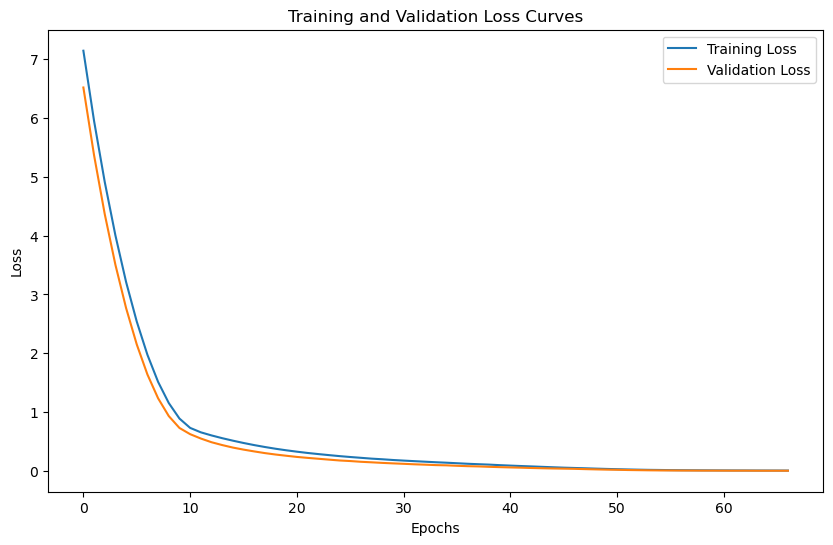

In [305]:
model = train_model(X_train, y_train,X_val, y_val, learning_rate = 0.0001,epochs=200)

In [306]:
current_dir = os.getcwd()
# Train your model here
model_path = current_dir + "/Model/"

model.save(model_path)

INFO:tensorflow:Assets written to: c:\Users\nbive\anaconda3\DS2 Project/Model/assets


INFO:tensorflow:Assets written to: c:\Users\nbive\anaconda3\DS2 Project/Model/assets


In [307]:
current_dir = os.getcwd()
# Train your model here
model_path = current_dir + "/Model/"

# Load the model
loaded_model = load_model(model_path)

In [308]:
current_dir = os.getcwd()
# Train your model here
folder_path = current_dir + "/Data/Test/"
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

test_dfs = []
for file in files:
    df = pd.read_csv(folder_path + file)
    test_dfs.append(df)

features = ["GR", "ILD", "DPHI"]


# Extract features and labels for training and validation sets
X_test = np.array([df[features].values for df in test_dfs])
y_test = np.array([df["Pick"].values for df in test_dfs])

# Normalize data
X_test = [normalize_data(x, mean, std) for x in X_test]

# Ensure even length
X_test = [ensure_even_length(x) for x in X_test]

# Compute max_length after ensuring even lengths
max_length = max(max(x.shape[0] for x in X_train), max(x.shape[0] for x in X_test))
max_length = adjust_max_length(max_length)



# Pad to max_length
X_test = [pad_to_max_length(x, max_length) for x in X_test]

# Ensure even length for labels and then pad
y_test = [ensure_even_length(y.reshape(-1, 1),padding_value=0) for y in y_test]
y_test = [pad_to_max_length(y, max_length,padding_value=0) for y in y_test]
y_test = [smooth_labels(y) for y in y_test]


C:\Users\nbive\AppData\Local\Temp\ipykernel_15568\2792885175.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array([df[features].values for df in test_dfs])
C:\Users\nbive\AppData\Local\Temp\ipykernel_15568\2792885175.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_test = np.array([df["Pick"].values for df in test_dfs])


In [309]:
def pad_dataframe(df, desired_length, padding_value=-99):
    # Calculate the number of rows to add
    num_rows_to_add = desired_length - len(df)
    
    # If the dataframe is already longer or equal to the desired length, return the original dataframe
    if num_rows_to_add <= 0:
        return df
    
    # Create a new dataframe with the required number of rows filled with the padding value
    padding_df = pd.DataFrame(padding_value, index=range(num_rows_to_add), columns=df.columns)
    
    # Concatenate the original dataframe with the padding dataframe
    padded_df = pd.concat([df, padding_df], axis=0).reset_index(drop=True)
    
    return padded_df



for i in range(len(X_test)):
    test_dfs[i]= pad_dataframe(test_dfs[i],desired_length=max_length)
    x_reshape = X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1])
    predictions = loaded_model.predict([x_reshape, x_reshape])
    binary_predictions = (predictions >= 0.5).astype(int)
    test_dfs[i]['Binary_Predict'] = binary_predictions.flatten()
    test_dfs[i]['Predict'] = predictions.flatten()
    

1/1 [==============================] - 0s 32ms/step


In [310]:
print(test_dfs[i].head())

     DEPT       GR    ILD   DPHI   SitID  Pick  Binary_Predict   Predict
0  180.00  123.706  3.911  0.243  179268     0               0  0.001436
1  180.25  123.131  3.910  0.237  179268     0               0  0.001367
2  180.50  121.975  3.838  0.238  179268     0               0  0.001381
3  180.75  121.408  3.837  0.246  179268     0               0  0.001391
4  181.00  122.036  3.836  0.243  179268     0               0  0.001401


In [311]:
# Ensure the directory exists
output_dir = os.path.join(current_dir, "Data", "Predictions")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through X_test and y_test
for df in test_dfs:
    name=df['SitID'][0]
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_dir, f"predictions_{name}.csv")
    df.to_csv(output_path, index=False)

In [312]:
actually_has_picks = []

# Create a new list to store the dataframes we want to keep
no_picks = []

for df in test_dfs:
    if sum(df['Binary_Predict']) > 0:
        actually_has_picks.append(df)
    else:
        no_picks.append(df)


print(f"Number of dataframes that actually has picks: {len(actually_has_picks)}")
print(f"Number of dataframes that has no picks: {len(no_picks)}")

Number of dataframes that actually has picks: 0
Number of dataframes that has no picks: 150


In [313]:
# 1. Error Metric
errors = np.abs(predictions - ground_truth)

# 2. Depth of Well for Marker
predicted_depths = np.argmax(predictions, axis=1)

# 3. Precision
def precision(errors, delta_T):
    M = len(errors)
    return np.sum(np.where(errors <= delta_T, 1, 0)) / M

# 4. Recall
def recall(errors, delta_T, N):
    return np.sum(np.where(errors <= delta_T, 1, 0)) / N

# 5. F1 Score
delta_T = 2  # in feet
prec = precision(errors, delta_T)
rec = recall(errors, delta_T, len(ground_truth))
F1 = 2 * (prec * rec) / (prec + rec)

# 6. Monte Carlo Dropout for Uncertainty
N = 100  # Number of predictions
predictions_mc = [model.predict(X_test) for _ in range(N)]
predictions_mean = np.mean(predictions_mc, axis=0)
predictions_std = np.std(predictions_mc, axis=0)

NameError: name 'ground_truth' is not defined